### Key Points:

1. **Using VEM/FEM Solutions for Efficient Training**:
   - By training the neural network on the displacement field computed using VEM/FEM, you're providing the model with a high-quality reference solution. This allows the model to learn the underlying physical relationships between the parameters (such as Young’s modulus \(E\), cross-sectional area \(A\), and moment of inertia \(I\)) and the displacement field.

2. **Generalization with Fewer Data**:
   - Since the model is grounded in physically informed solutions, you likely need **fewer training examples** to generalize to new material and geometrical configurations. Unlike traditional machine learning models that require vast amounts of labeled data, your approach can rely on solving a **few instances** of VEM/FEM solutions and using that information to generalize.

3. **Parameter Sensitivity and Inference**:
   - The network’s sensitivity to material and geometrical parameters (\(E\), \(A\), \(I\)) is key. Once trained, the model will allow for **rapid inference** with new combinations of these parameters without needing to solve the full VEM/FEM system again.
   - In an engineering context, this is particularly advantageous, as engineers often need to explore various material or geometric configurations during design optimization. Having a trained neural network that provides **instant predictions** without solving a full VEM/FEM problem would significantly improve efficiency.

4. **Efficiency Compared to Traditional VEM/FEM**:
   - Solving a full VEM/FEM problem repeatedly for different parameter values can be computationally expensive, especially for large or complex systems. By training a neural network to approximate the displacement field based on these parameters, you essentially create a **surrogate model** that can make predictions more efficiently.

### Challenges and Considerations:
- **Accuracy vs. Efficiency**: While the neural network may provide fast predictions, the trade-off is the potential for reduced accuracy compared to solving the full VEM/FEM system. This can be mitigated by fine-tuning the network and introducing additional regularization techniques like Sobolev training.
  
- **Extrapolation Limits**: The network might struggle with extrapolating far beyond the range of material and geometrical parameters it was trained on. Ensuring that the training data includes a representative range of parameters will be crucial for reliable generalization.

- **Hybrid Model Validation**: You could validate your hypothesis by comparing the **computational cost** (in terms of time) and **accuracy** between solving multiple VEM/FEM instances and using the trained neural network for inference over a variety of material/geometrical configurations.

### Conclusion:
The approach of training a neural network using VEM/FEM solutions to enable efficient inference of displacement fields for different material and geometric configurations is a practical and promising solution in engineering contexts. It leverages the strengths of both numerical methods and machine learning to balance accuracy and efficiency.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import core.vem as vem
from typing import Tuple

import utils.mesh as mesh
import core.loss as loss_function
import core.errors as errors
import core.neural_backend as neural

import solve_vem

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend is available!")
else:
    device = torch.device("cpu")
    print("MPS backend is not available. Using CPU.")

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

MPS backend is available!


In [3]:
# Define the number of elements per edge
num_elements_per_edge = 8

# geometry data
L = 2.0
I = 1e-4
A = 1

# material data
E = 27e6

# Define load parameters
q = -400
t = 0

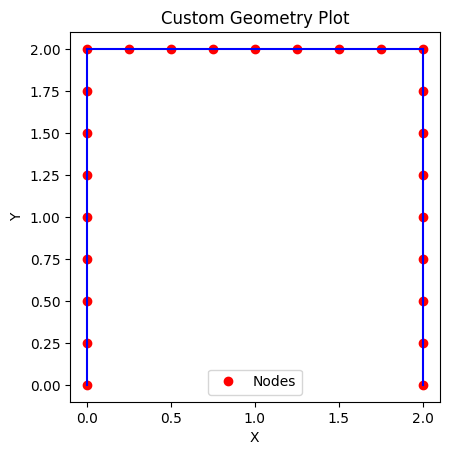


######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.12147489e-08
 -6.51147254e-06  3.70125911e-08 -3.82771235e-08 -1.30229451e-05
 -3.32189939e-08 -4.93979584e-08 -1.95344176e-05 -1.05197265e-08
 -2.66683517e-08 -2.60458901e-05 -3.04022527e-07 -1.35172804e-07
 -3.25573627e-05  1.03935275e-06  3.83993619e-07 -3.90688352e-05
 -5.32538953e-06 -2.07509973e-06 -4.55803078e-05  2.48654309e-05
  9.58589532e-06 -5.20917803e-05 -1.18286097e-04  9.58557682e-06
 -4.43646980e-04 -4.93943178e-04  9.58525833e-06 -6.91673740e-04
  6.44138955e-04  9.58493984e-06 -6.79341446e-04  1.20312678e-03
  9.58462134e-06 -5.50194180e-04  1.19285626e-03  9.58430285e-06
 -4.01630820e-04  9.72653070e-04  9.58398436e-06 -2.62546369e-04
  7.31222515e-04  9.58366586e-06 -1.30503847e-04  5.30515161e-04
  9.58334737e-06 -7.16747896e-06  2.75770824e-04  3.60386617e-05
 -6.27154409e-06 -6.39956041e-05  1.78784816e-05 -5.37560922e-06
 -8.11531315e-05  3.57724107e-0

In [4]:
# Generate the geometry
nodes, elements, supp, load = mesh.generate_portic_geometry(num_elements_per_edge, L)

# Plot the nodes
mesh.plot_nodes(nodes, elements)

# Solve the problem using the VEM
uh_vem, K, f = solve_vem.solve_1d(nodes, elements, supp, E, A, I, load, q, t)

The model refers to the disaplcement field and the loss function regards to the calculation of the residual taking in consideration the Virtual Element Method's stiffness matrix and load vector.

In [5]:
material_params = torch.tensor([E, A, I], dtype=torch.float32)
normalized_nodes, normalized_material_params = neural.normalize_inputs(nodes, material_params)

/Users/pauloakira/Main/_repos/ai-pinn/core/neural_backend.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_nodes = torch.tensor(normalized_nodes, dtype=torch.float32, requires_grad=True)
/Users/pauloakira/Main/_repos/ai-pinn/core/neural_backend.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_material_params = torch.tensor(normalized_material_params, dtype=torch.float32, requires_grad=True)


Material params shape: torch.Size([3])
Nodes shape: torch.Size([50])


/Users/pauloakira/Main/_repos/ai-pinn/core/neural_backend.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)
/opt/anaconda3/envs/ml-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 1, Total Loss: 0.061261965205514836
Epoch: 2, Total Loss: 0.01002299677826391
Epoch: 3, Total Loss: 0.005560831874425354
Epoch: 4, Total Loss: 0.002883271935826758
Epoch: 5, Total Loss: 0.0021075829071209883
Epoch: 6, Total Loss: 0.0008855082330538827
Epoch: 7, Total Loss: 0.0008678538914306728
Epoch: 8, Total Loss: 0.00040615083344053987
Epoch: 9, Total Loss: 0.000237791022417616
Epoch: 10, Total Loss: 0.00018819835080666837
Epoch: 11, Total Loss: 0.00016441116375835648
Epoch: 12, Total Loss: 0.00010496271319674309
Epoch: 13, Total Loss: 6.355400740467707e-05
Epoch: 14, Total Loss: 5.349430267904192e-05
Epoch: 15, Total Loss: 5.2641291235579096e-05
Epoch: 16, Total Loss: 5.1092818884722636e-05
Epoch: 17, Total Loss: 3.650059566980799e-05
Epoch: 18, Total Loss: 2.1116509576679094e-05
Epoch: 19, Total Loss: 1.83392688264606e-05
Epoch: 20, Total Loss: 1.8551965314473625e-05
Epoch: 21, Total Loss: 2.016768196149752e-05
Epoch: 22, Total Loss: 1.7968327607669042e-05
Epoch: 23, Total 

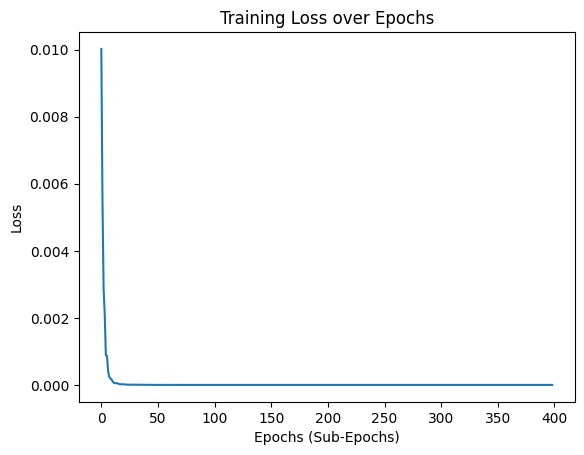

In [6]:
# Hyperparameters
num_epochs = 400

# Layers definition
nodes_layers = [128, 256, 512, 512, 512, 512]  # Layers for nodes sub-network
material_layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 2048] # Layers for materials sub-network
final_layers = [1024, 1024, 1024, 1024]  # Layers for final combination network

# Training pipeline
(input_vector, 
 model, 
 total_loss_values, 
 loss_values, 
 material_loss_values, 
 sobolev_loss_values, 
 alpha_values_values) = neural.train_material_portic(
    epochs=num_epochs,
    nodes=nodes,
    K=K,
    f=f,
    E=E,
    A=A,
    I=I,
    uh_vem=uh_vem,
    nodes_layers=nodes_layers,
    material_layers=material_layers,
    final_layers=final_layers,
    verbose=True,
    noramlize_inputs=True,
    network_type="material"
 )

Given the reference displacement field calculated by the Virtual Element Method, a displacemente field is supposed to be calculated considering the material parameters contributions to it.

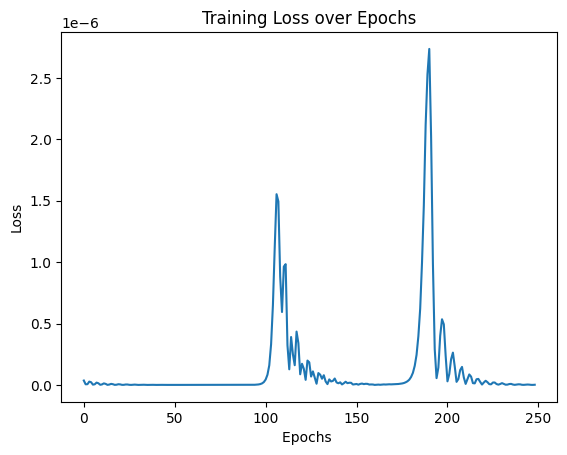

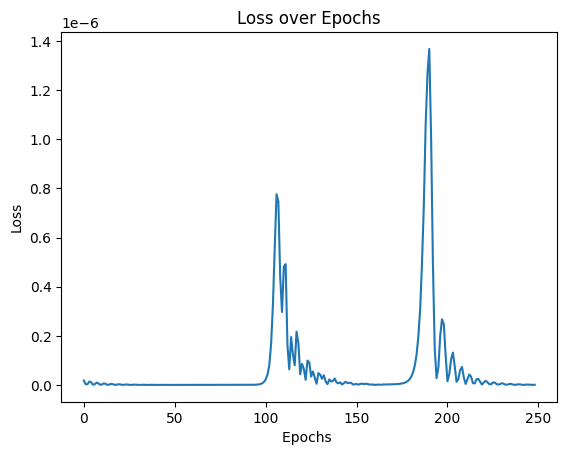

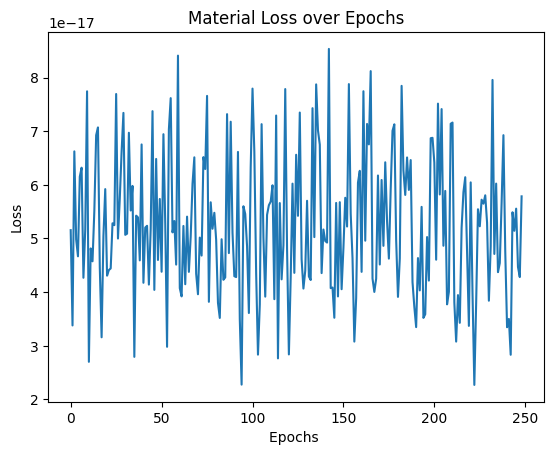

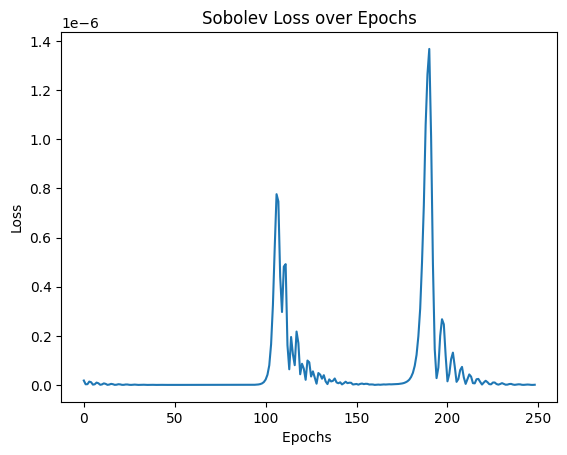

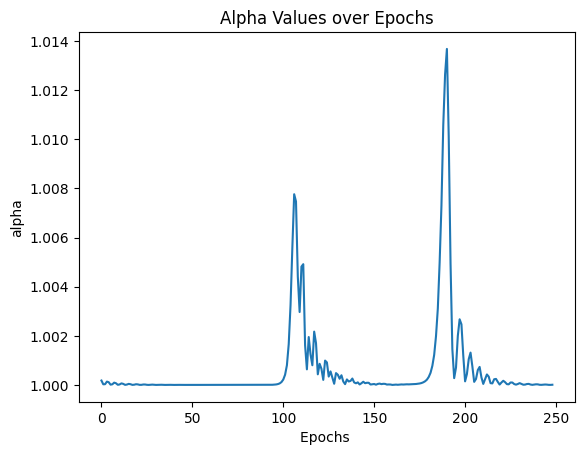

In [7]:
filtered_total_loss = total_loss_values[150:]
plt.plot(filtered_total_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

filtered_loss = loss_values[150:]
plt.plot(filtered_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

filtered_material_loss = material_loss_values[150:]
plt.plot(filtered_material_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Material Loss over Epochs')
plt.show()

filtered_sobolev_loss = sobolev_loss_values[150:]
plt.plot(filtered_sobolev_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Sobolev Loss over Epochs')
plt.show()

filtered_alpha_values = alpha_values_values[150:]
plt.plot(filtered_alpha_values)
plt.xlabel('Epochs ')
plt.ylabel('alpha')
plt.title('Alpha Values over Epochs')
plt.show()

In [8]:
material_params = torch.tensor([E , A , I ], dtype=torch.float32)
# nodes = torch.tensor(nodes.flatten(), dtype=torch.float32)
nodes, material_params = neural.normalize_inputs(nodes, material_params)

predicted_displacements, l2_error, energy_error, h1_error, inference_time = neural.test_portic(
    nodes=nodes,
    material_params=material_params,
    model=model,
    uh_vem=uh_vem,
    K=K,
    f=f,
    concatanate=False
)

print(f"L2 error: {l2_error}")
print(f"Energy error: {energy_error}")
print(f"H1 error: {h1_error}")

Predicted displacements: tensor([ 1.6226e-06, -3.7476e-06,  5.0785e-06,  2.1172e-06, -1.1383e-05,
        -3.6089e-06,  5.5451e-06, -1.7284e-05, -3.6252e-07,  6.3051e-06,
        -1.9297e-05,  3.2466e-06,  3.8138e-06, -2.6701e-05,  3.5088e-06,
        -1.7034e-06, -2.8591e-05,  1.3970e-09,  3.5089e-06, -4.2575e-05,
        -8.5509e-06,  2.0468e-06, -4.4318e-05,  3.0277e-05,  4.5174e-06,
        -5.3064e-05, -1.1315e-04,  5.7900e-06, -4.4614e-04, -4.9099e-04,
         1.4943e-05, -6.9402e-04,  6.4624e-04,  1.0533e-05, -6.8036e-04,
         1.2031e-03,  1.2759e-05, -5.5400e-04,  1.1888e-03,  7.5479e-06,
        -4.0417e-04,  9.7408e-04,  1.0339e-05, -2.6026e-04,  7.2691e-04,
         3.1656e-06, -1.2423e-04,  5.2677e-04,  1.2443e-05, -4.4107e-06,
         2.7913e-04,  3.5721e-05, -1.0337e-05, -5.8441e-05,  2.2172e-05,
        -1.0690e-05, -7.7159e-05,  3.9998e-06, -7.5148e-06, -3.4935e-05,
        -5.5707e-06,  1.7490e-06, -4.6797e-06, -3.0310e-06,  1.4249e-06,
         2.3944e-06,  4.56

/Users/pauloakira/Main/_repos/ai-pinn/core/neural_backend.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_nodes = torch.tensor(normalized_nodes, dtype=torch.float32, requires_grad=True)
/Users/pauloakira/Main/_repos/ai-pinn/core/neural_backend.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_material_params = torch.tensor(normalized_material_params, dtype=torch.float32, requires_grad=True)
/Users/pauloakira/Main/_repos/ai-pinn/core/errors.py:35: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permut

In [9]:
# New geometry parameter
I = 1e-4
A = 5
E = 110e5

# Generate the geometry
nodes, elements, supp, load = mesh.generate_portic_geometry(num_elements_per_edge, L)

# Solve the problem using the VEM
uh_vem, K, f = solve_vem.solve_1d(nodes, elements, supp, E, A, I, load, q, t)


######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.73281626e-08
 -3.17152131e-06  1.21079720e-07 -1.18586344e-07 -6.34304261e-06
 -1.28559846e-07 -1.64579641e-07 -9.51456392e-06  7.89606360e-08
 -4.05649025e-08 -1.26860852e-05 -1.48862412e-06 -6.30804169e-07
 -1.58576065e-05  5.79299268e-06  2.18263076e-06 -1.90291278e-05
 -2.87180177e-05 -1.11495820e-05 -2.22006492e-05  1.34958174e-04
  5.20701468e-05 -2.53721705e-05 -6.41133550e-04  5.20699463e-05
 -1.04785984e-03 -1.40491663e-03  5.20697459e-05 -1.68188215e-03
  1.51961966e-03  5.20695455e-05 -1.65491865e-03  2.93600017e-03
  5.20693451e-05 -1.33546513e-03  2.91257014e-03  5.20691447e-05
 -9.68876039e-04  2.36611501e-03  5.20689442e-05 -6.27068927e-04
  1.76734461e-03  5.20687438e-05 -3.02044164e-04  1.28488652e-03
  5.20685434e-05 -3.71873863e-06  6.06780206e-04  1.00545733e-04
 -3.25389630e-06 -2.18545144e-04  4.55962047e-05 -2.78905398e-06
 -2.20633536e-04  7.64980996e-0

In [10]:
material_params = torch.tensor([E , A , I ], dtype=torch.float32)
nodes = torch.tensor(nodes.flatten(), dtype=torch.float32)
nodes, material_params = neural.normalize_inputs(nodes, material_params)
# predicted_displacements, l2_error, energy_error, h1_error = test(nodes, material_params, model, uh_vem, K, f, concatanate=False)
predicted_displacements, l2_error, energy_error, h1_error, inference_time = neural.test_portic(
    nodes=nodes,
    material_params=material_params,
    model=model,
    uh_vem=uh_vem,
    K=K,
    f=f,
    concatanate=False
)
print(f"L2 error: {l2_error}")
print(f"Energy error: {energy_error}")
print(f"H1 error: {h1_error}")

Predicted displacements: tensor([ 1.6221e-06, -3.7481e-06,  5.0804e-06,  2.1167e-06, -1.1384e-05,
        -3.6070e-06,  5.5451e-06, -1.7285e-05, -3.6205e-07,  6.3060e-06,
        -1.9296e-05,  3.2457e-06,  3.8119e-06, -2.6701e-05,  3.5092e-06,
        -1.7053e-06, -2.8592e-05,  1.3970e-09,  3.5098e-06, -4.2575e-05,
        -8.5512e-06,  2.0457e-06, -4.4320e-05,  3.0278e-05,  4.5188e-06,
        -5.3064e-05, -1.1315e-04,  5.7900e-06, -4.4614e-04, -4.9100e-04,
         1.4945e-05, -6.9403e-04,  6.4624e-04,  1.0533e-05, -6.8036e-04,
         1.2031e-03,  1.2760e-05, -5.5400e-04,  1.1888e-03,  7.5488e-06,
        -4.0417e-04,  9.7409e-04,  1.0339e-05, -2.6026e-04,  7.2691e-04,
         3.1642e-06, -1.2423e-04,  5.2677e-04,  1.2444e-05, -4.4098e-06,
         2.7913e-04,  3.5721e-05, -1.0337e-05, -5.8441e-05,  2.2171e-05,
        -1.0690e-05, -7.7159e-05,  3.9992e-06, -7.5148e-06, -3.4936e-05,
        -5.5700e-06,  1.7500e-06, -4.6799e-06, -3.0315e-06,  1.4249e-06,
         2.3935e-06,  4.56